In [148]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("credit_analysis") \
    .getOrCreate()


In [149]:
df_original=spark.read.format("csv").option("header","true").load('./data.csv', inferSchema=True)

In [150]:
df_original.count()

855969

## We realised there's many rows that have more delimeters than the others, therefore, we decided to remove some record with wrong delimeter before hand

In [151]:
def remove_lines_with_excessive_commas(input_file, output_file):
    with open(input_file, 'r') as csv_input, open(output_file, 'w', newline='') as csv_output:
        first_line = csv_input.readline()
        csv_output.write(first_line)
        number_of_comma = first_line.count(',')
        lines_removed = 0

        for row in csv_input.readlines():
            
            if row.count(',') <= number_of_comma:
                csv_output.write(row)
            else:
                lines_removed += 1

        print(f"{lines_removed} Lines with more than {number_of_comma} commas have been removed.")

# Usage example
input_file = 'data.csv'
output_file = 'output.csv'

In [152]:
remove_lines_with_excessive_commas(input_file, output_file)

51895 Lines with more than 72 commas have been removed.


In [153]:
df=spark.read.format("csv").option("header","true").load('./output.csv', inferSchema=True)

In [154]:
df.count()

804074

In [155]:
df.show(5)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

# Stage 1: Data exploration

In [156]:
df.dtypes

[('id', 'int'),
 ('member_id', 'int'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'double'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('pymnt_plan', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'double'),
 ('delinq_2yrs', 'int'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'int'),
 ('mths_since_last_delinq', 'int'),
 ('mths_since_last_record', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'double'),
 ('total_acc', 'int'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'double'),
 ('out_prncp_inv', 'double'),
 ('total_pymnt', 'double'),
 ('total_pymnt_inv', 'double

In [157]:
column_to_hist = [item[0] for item in df.dtypes if item[1].startswith('int') or item[1].startswith('double')]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'member_id'}>,
        <AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'mths_since_last_delinq'}>,
        <AxesSubplot:title={'center':'mths_since_last_record'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'cente

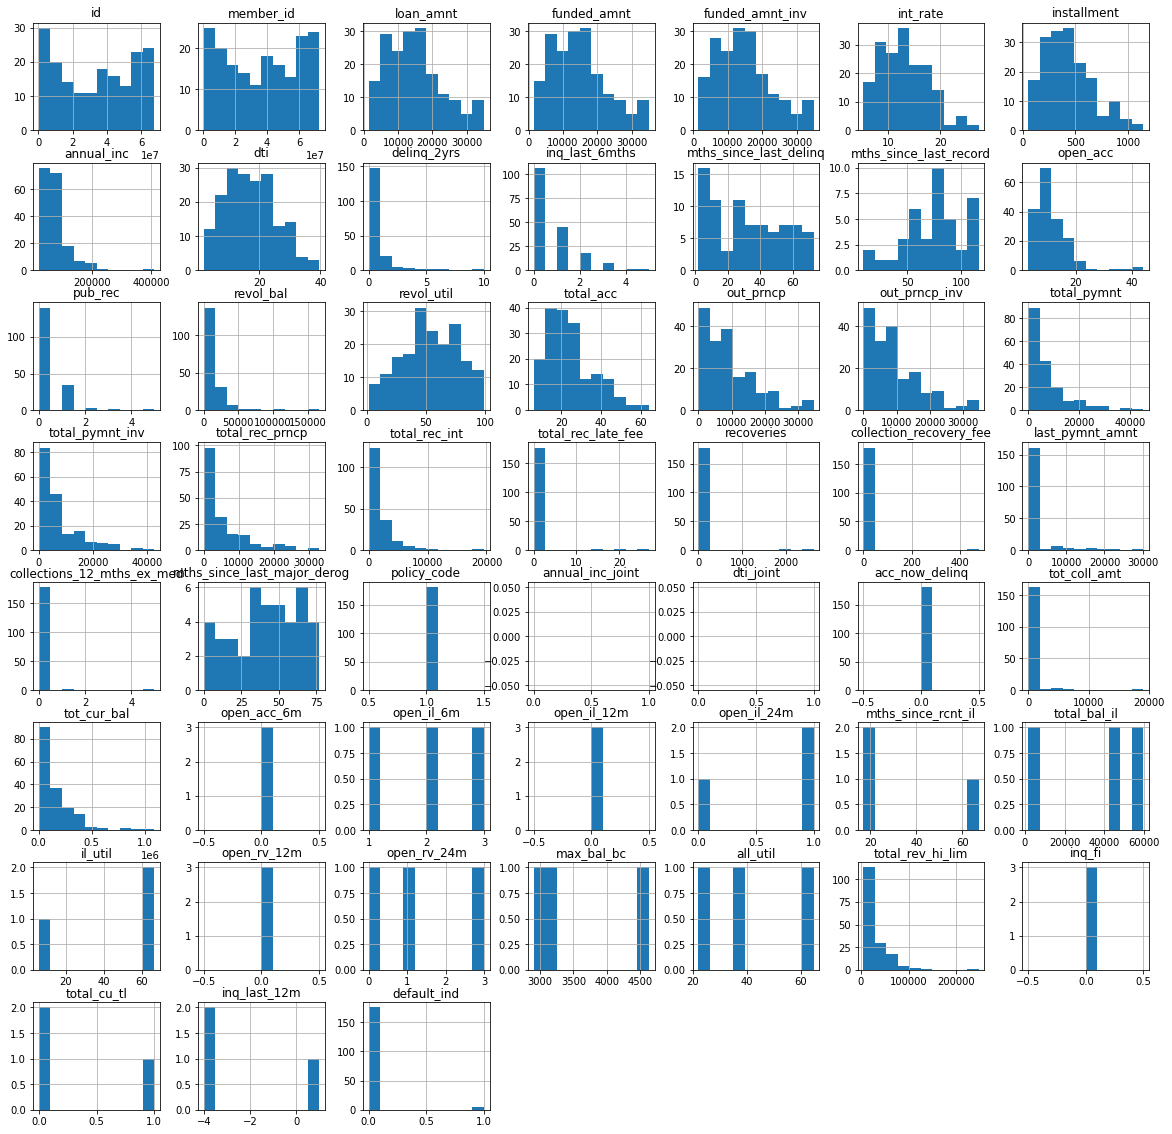

In [158]:
df.select(column_to_hist).sample(withReplacement=False, fraction=0.0002, seed=None).toPandas().hist(figsize=(20,20))

In [159]:
df.columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 '

From the domain knowledge, it is noticeable that the following fields could be removed as they do not provide great insight for the prediction, and may introduce noise and cause overfitting:

- Unique identifiers such as `id` and `member_id`
- `emp_title`, `desc`, `title` as text description of the loan won't be contribute much for the prediction
- Location identifier columns such as `zip_code` and `addr_state`, as these information do not expected to have a strong influence on loan defaults 
- Date columns such as `earliest_cr_line`, `issue_d`, `last_pymnt_d`, `next_pymnt_d`, `last_credit_pull_d` can be removed, as these data might not be relevant for the prediction model. Moreover, the model to be implemented is expected to predict the upcoming loan, and these date data might not be available.

In [160]:
df = df.drop('id', 'member_id', 'emp_title', 'desc', 'emp_title', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d')

In [161]:
df.show()

+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|  

In [162]:
len(df.columns)

61

In [163]:
df.groupBy(df["policy_code"]).count().sort("count", ascending=False).show()

+-----------+------+
|policy_code| count|
+-----------+------+
|          1|804074|
+-----------+------+



All the policy has the same policy_code. Therefore this column will be dropped

In [164]:
df = df.drop('policy_code')

In [165]:
df.groupBy(df["default_ind"]).count().show()

+-----------+------+
|default_ind| count|
+-----------+------+
|          1| 40660|
|          0|763414|
+-----------+------+



5% of the data are `default`

Visualisation of default diagram

In [166]:
df.groupby(['default_ind']).count().to_pandas_on_spark(index_col='default_ind').plot.pie(y='count')

We will need to resample a training data that will have equal distribution (50/50) of default and non-default rows

In [167]:
df.groupby(['home_ownership']).count().show()


+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN| 80448|
|          RENT|320233|
|      MORTGAGE|403274|
|         OTHER|    81|
|          NONE|    35|
|           ANY|     3|
+--------------+------+



The majority of borrowers are either paying mortgage or renting a home. Around 10% of borrower actually own the house. Lastly, around 0.0148% of borrowers are in the OTHER, NONE, and ANY category. These remaining fields should be consolidate into one as 'OTHER' field.

In [168]:
df = df.replace(['NONE', 'ANY', '2 years'], 'OTHER', 'home_ownership')

In [169]:
df.select(['home_ownership']).distinct().show()

+--------------+
|home_ownership|
+--------------+
|           OWN|
|          RENT|
|      MORTGAGE|
|         OTHER|
+--------------+



In [170]:
df.groupby(['home_ownership']).count().to_pandas_on_spark(index_col='home_ownership').plot.pie(y='count')

Let's check for the default rate among all home ownership types

In [171]:
df.select(['default_ind','home_ownership']).filter(df['default_ind'] == 1).groupby(['home_ownership']).count().show()

+--------------+-----+
|home_ownership|count|
+--------------+-----+
|           OWN| 3699|
|          RENT|19203|
|      MORTGAGE|17743|
|         OTHER|   15|
+--------------+-----+



Tenants/renter seems more likely to default a loan

In [172]:
df.select(['default_ind','home_ownership']).filter(df['default_ind'] == 0).groupby(['home_ownership']).count().show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN| 76749|
|          RENT|301030|
|      MORTGAGE|385531|
|         OTHER|   104|
+--------------+------+



In [173]:
df.select(['pymnt_plan']).groupby(['pymnt_plan']).count().show()

+----------+------+
|pymnt_plan| count|
+----------+------+
|         n|804071|
|         y|     3|
+----------+------+



Everything in this column is no, except for 3 yes. Therefore this column will be dropped

In [174]:
df = df.drop('pymnt_plan')

In [175]:
df.show()

+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs

In [176]:
df.select(['initial_list_status']).groupby(['initial_list_status']).count().to_pandas_on_spark(index_col='initial_list_status').plot.pie(y='count')

In [177]:
df.select('funded_amnt', 'funded_amnt_inv').show(5)

+-----------+---------------+
|funded_amnt|funded_amnt_inv|
+-----------+---------------+
|       5000|         4975.0|
|       2500|         2500.0|
|       2400|         2400.0|
|       5000|         5000.0|
|       3000|         3000.0|
+-----------+---------------+
only showing top 5 rows



In [178]:
df.select('funded_amnt', 'funded_amnt_inv').filter(df['funded_amnt'] == df['funded_amnt_inv']).count()

722842

In [179]:
df.select('funded_amnt', 'funded_amnt_inv').filter(df['funded_amnt'] > df['funded_amnt_inv']).count()

81232

In [180]:
df.select('out_prncp', 'out_prncp_inv').filter(df['out_prncp'] == df['out_prncp_inv']).count()

755007

The majority of the `funded_amnt_inv` and `out_prncp_inv` seems to be identical with the `funded_amnt` and `out_prncp` respectively. Furthermore, information about payout and investment of investor does not seem to concern with the loan itself. Therefore these two columns will be removed

In [181]:
df = df.drop('funded_amnt_inv', 'out_prncp_inv')

In [182]:
df.show(5)

+---------+-----------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
|loan_amnt|funded_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last

In [183]:
df.select('collections_12_mths_ex_med').groupBy('collections_12_mths_ex_med').count().show()

+--------------------------+------+
|collections_12_mths_ex_med| count|
+--------------------------+------+
|                      null|    34|
|                         1| 10159|
|                         2|   704|
|                         0|793062|
|                         3|    79|
|                         6|     2|
|                        16|     1|
|                        20|     1|
|                         4|    22|
|                         5|     7|
|                         7|     1|
|                        10|     1|
|                        14|     1|
+--------------------------+------+



The majority of the `collections_12_mths_ex_med` are 0, let's see if there's any impact of this column when its more than 0 on the `default_ind`

In [184]:
df.filter((df['collections_12_mths_ex_med'] > 0)).count()

10978

In [185]:
df.filter((df['collections_12_mths_ex_med'] > 0) & (df['default_ind'] == 1)).count()

357

=> The majority of the values when `collections_12_mths_ex_med` > 0 end up as non-default 

## Observation on `null` data fields:

In [186]:
null_dict = {col : df.filter(df[col].isNull()).count() for col in df.columns}

In [187]:
null_dict

{'loan_amnt': 0,
 'funded_amnt': 0,
 'term': 0,
 'int_rate': 0,
 'installment': 0,
 'grade': 0,
 'sub_grade': 0,
 'emp_length': 0,
 'home_ownership': 0,
 'annual_inc': 0,
 'verification_status': 0,
 'purpose': 0,
 'dti': 0,
 'delinq_2yrs': 0,
 'inq_last_6mths': 0,
 'mths_since_last_delinq': 408833,
 'mths_since_last_record': 677326,
 'open_acc': 0,
 'pub_rec': 0,
 'revol_bal': 0,
 'revol_util': 401,
 'total_acc': 0,
 'initial_list_status': 0,
 'out_prncp': 0,
 'total_pymnt': 0,
 'total_pymnt_inv': 0,
 'total_rec_prncp': 0,
 'total_rec_int': 0,
 'total_rec_late_fee': 0,
 'recoveries': 0,
 'collection_recovery_fee': 0,
 'last_pymnt_amnt': 0,
 'collections_12_mths_ex_med': 34,
 'mths_since_last_major_derog': 597237,
 'application_type': 0,
 'annual_inc_joint': 803633,
 'dti_joint': 803633,
 'verification_status_joint': 803633,
 'acc_now_delinq': 0,
 'tot_coll_amt': 45453,
 'tot_cur_bal': 45453,
 'open_acc_6m': 790893,
 'open_il_6m': 790893,
 'open_il_12m': 790893,
 'open_il_24m': 790893,


- all `*_joint` columns (`annual_inc_joint`, `dti_joint`, `verification_status_joint`) have 803633 null values, equivalent to the number of `INDIVIDUAL` `application_type` rows -> Therefore, only the `application_type` of `JOINT` will have these columns filled

Sometime null does not mean we are missing data
- `null` value for `mths_since_last_delinq` indicate that this borrower does not have any delinquencies (does not behind on payment) record.
- `null` value for `mths_since_last_record` indicate that this borrower does not have any public record (does not have any public records of bankruptcy and judgement information)
- `null` value for `mths_since_last_major_derog` indicate that this borrower does not have any worse rating in the last 90 days


In [188]:
df.groupby(['application_type']).count().to_pandas_on_spark(index_col=['application_type']).plot.pie(y='count')

The number of data with `application_type == 'JOINT'`  are heavily underrepresent

Checking if there's any default cases when `application_type == 'JOINT'`

In [189]:
df.filter((df['application_type'] == "JOINT") & (df['default_ind'] == '1')).count()

0

Base on the dataset, virutally no `default` happened when the `application_type == 'JOINT'`!

In [190]:
df_original.filter(df_original['application_type'] == "JOINT").count()

442

We only remove 1 `"JOINT"` account from cleaning the CSV dataset

Because of high percentage of missing values in the columns related to joint application, the columns related to this will be dropped

In [191]:
df = df.drop("annual_inc_joint", "dti_joint", "verification_status_joint")

In [192]:
df.groupBy(df['verification_status']).count().show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|259501|
|    Source Verified|304870|
|       Not Verified|239703|
+-------------------+------+



In [193]:
df.groupBy(df['verification_status'])\
    .count()\
    .to_pandas_on_spark(index_col=['verification_status'])\
    .plot.pie(y='count')

=> Evenly distributed `verfication_status` accross all accounts 

Let's see the relationship between the number of personal finance inquiries (`inq_fi`) and default rate

In [194]:
df.filter(df['inq_fi'].isNotNull() & (df['default_ind'] == 1)).count()

0

=> All the borrowers with a record of personal finance inquiries virtually not default. If this field is `null`, it indicate that the borrowers never inquiries any personal finance advice from this firm.

Because of the high volume of missing values, this column will be dropped

In [195]:
df = df.drop('inq_fi')

Next, let's see the relationship between the number of credit inquiries in the last 12 months (`inq_last_12m`) and default rate

In [196]:
df.filter(df['inq_last_12m'].isNotNull()).sort('inq_last_12m', ascending=False).show()

+---------+-----------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+----------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+-----------+------------+-----------+
|loan_amnt|funded_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last_record|open_acc|pub_rec|revol_bal|revol_util|total_

In [197]:
df.filter(df['inq_last_12m'].isNotNull() & (df['default_ind'] == 1)).sort('inq_last_12m', ascending=False).count()

0

In real life, higher number of number of credit inquiries will result in lower result credit, making this loan has a higher chance of default (https://www.canstar.com.au/credit-score/do-credit-checks-affect-your-credit-score/). However it is the opposite with this dataset, as more credit inquiries result in no default rate!

In [198]:
df.filter((df['inq_last_6mths'] != 0) & (df['default_ind'] == 1)).sort('inq_last_6mths', ascending=False).count()

22935

In [199]:
df.filter((df['inq_last_6mths'] != 0)).count()

348439

On the other hand, for the `inq_last_6mths` values that not 0, a portion of the data does end up as default. Therefore this column should be kept as it would be a good weight for our ML model, whilst the `inq_last_12m` will be dropped

In [200]:
df = df.drop('inq_last_12m')

For the rest of the high number of missing values columns, they will also be dropped.

In [201]:
df = df.drop('open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_cu_tl', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog')

In [202]:
{col : df.filter(df[col].isNull()).count() for col in df.columns}

{'loan_amnt': 0,
 'funded_amnt': 0,
 'term': 0,
 'int_rate': 0,
 'installment': 0,
 'grade': 0,
 'sub_grade': 0,
 'emp_length': 0,
 'home_ownership': 0,
 'annual_inc': 0,
 'verification_status': 0,
 'purpose': 0,
 'dti': 0,
 'delinq_2yrs': 0,
 'inq_last_6mths': 0,
 'open_acc': 0,
 'pub_rec': 0,
 'revol_bal': 0,
 'revol_util': 401,
 'total_acc': 0,
 'initial_list_status': 0,
 'out_prncp': 0,
 'total_pymnt': 0,
 'total_pymnt_inv': 0,
 'total_rec_prncp': 0,
 'total_rec_int': 0,
 'total_rec_late_fee': 0,
 'recoveries': 0,
 'collection_recovery_fee': 0,
 'last_pymnt_amnt': 0,
 'collections_12_mths_ex_med': 34,
 'application_type': 0,
 'acc_now_delinq': 0,
 'tot_coll_amt': 45453,
 'tot_cur_bal': 45453,
 'total_rev_hi_lim': 45453,
 'default_ind': 0}

### Impute the remaining null data

In [203]:
from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols=['tot_coll_amt', 'total_rev_hi_lim', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med'],
    outputCols=['tot_coll_amt', 'total_rev_hi_lim', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med']
)

df = imputer.setStrategy("median").fit(df).transform(df)

In [204]:
df.show()

+---------+-----------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+
|loan_amnt|funded_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|collections_12_mths_ex_med|application_type|acc_now_delinq|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|


In [205]:
df.select('emp_length').groupBy('emp_length').count().to_pandas_on_spark(index_col=['emp_length']).plot.pie(y='count')

# Stage 2: Predictive analysis 

One Hot Encoding all the categorical value

In [206]:
categorical_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]

In [207]:
categorical_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

In [208]:
onehot_output_cols = list(map(lambda col : f"{col}_onehot", categorical_cols))

In [209]:
numeric_output_cols = list(map(lambda col : f"{col}_numeric", categorical_cols))

In [210]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer = StringIndexer(inputCols=categorical_cols, outputCols=numeric_output_cols)
indexer_fitted = indexer.fit(df)
df_indexed = indexer_fitted.transform(df)

one_hot = OneHotEncoder(inputCols=numeric_output_cols, outputCols=onehot_output_cols)
one_hot_df = one_hot.fit(df_indexed).transform(df_indexed)
df_one_hot = one_hot_df.drop(*numeric_output_cols, *categorical_cols)


## Process the training/testing data

### Resampling the training data with 50% default and 50% non-default

In [211]:
default_records = df_one_hot.filter(df['default_ind'] == 1).count()

In [212]:
non_default_records = df_one_hot.filter(df['default_ind'] == 0).count()

In [213]:
X = df_one_hot.sampleBy("default_ind", fractions={0: default_records/non_default_records, 1: 1}, seed=42)

In [214]:
X.filter(X['default_ind'] == 1).count()

40660

In [215]:
X.filter(X['default_ind'] == 0).count()

40928

In [216]:
X.groupBy('default_ind').count().to_pandas_on_spark(index_col='default_ind').plot.pie(y='count')

Now that our training data is well sampled, let's split the training data into 70% training and 30% testing

In [217]:
(train, test) = X.randomSplit([0.7, 0.3], seed=42)

## Process One (3 ML Models with Spark ML)

In [218]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import DoubleType, FloatType

In [219]:
columns = df_one_hot.columns
columns.remove('default_ind')

In [220]:
vector_assembler = VectorAssembler(
    inputCols=columns,
    outputCol="features"
)

In [221]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def graph_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [222]:
def get_spark_ml_perf(predictions):
    binary_eval = BinaryClassificationEvaluator(labelCol='label')
    evaluate_accuracy = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="accuracy")
    evaluate_precision = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="precisionByLabel")
    evaluate_recall = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="recallByLabel")
    evaluate_f1 = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="f1")
    roc = binary_eval.evaluate(predictions.withColumn('label', predictions['default_ind'].cast(DoubleType())))

    accuracy=evaluate_accuracy.evaluate(predictions)
    precision=evaluate_precision.evaluate(predictions)
    recall=evaluate_recall.evaluate(predictions)

    print("Summary Stats")
    print("Accuracy = %s" % accuracy)
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("Area under ROC = %s" % roc)
    graph_roc_curve(predictions.select(predictions['default_ind']).toPandas(), predictions.select(predictions['prediction']).toPandas())
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
    }

### Decision Tree

In [223]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

In [224]:
decision_tree = DecisionTreeClassifier(labelCol='default_ind', featuresCol='features')

In [225]:
pipeline = Pipeline(stages=[vector_assembler, decision_tree])

In [226]:
decision_tree_clf = pipeline.fit(train)

In [227]:
predictions = decision_tree_clf.transform(test)

In [228]:
predictions.show()

+---------+-----------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+--------------+------------+-----------+----------------+-----------+-------------+-------------+----------------+-----------------+---------------------+--------------------------+--------------+--------------------------+-----------------------+--------------------+---------------+--------------------+----------+
|loan_amnt|funded_amnt|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|collections_12_mths_ex_med|acc_now_delinq|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|  term_oneho

Summary Stats
Accuracy = 0.9686403961213121
Precision = 0.9653089543710718
Recall = 0.9724529232793356
F1 Score = 0.9686395455250653
Area under ROC = 0.9760033605500777


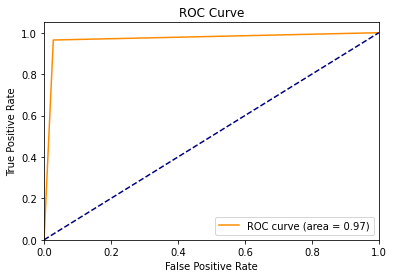

{'accuracy': 0.9686403961213121,
 'precision': 0.9653089543710718,
 'recall': 0.9724529232793356,
 'f1': 0.9686395455250653}

In [229]:
get_spark_ml_perf(predictions)

## Random Forest

In [230]:
from pyspark.ml.classification import RandomForestClassifier

In [231]:
random_forest = RandomForestClassifier(labelCol='default_ind', featuresCol='features')

In [232]:
rdn_forest_pipeline = Pipeline(stages=[vector_assembler, random_forest])

In [233]:
random_forest_tree_clf = rdn_forest_pipeline.fit(train)

In [234]:
predictions = random_forest_tree_clf.transform(test)

In [235]:
predictions.select('default_ind', 'prediction').show()

+-----------+----------+
|default_ind|prediction|
+-----------+----------+
|          1|       1.0|
|          0|       1.0|
|          0|       1.0|
|          1|       1.0|
|          1|       1.0|
|          0|       1.0|
|          1|       1.0|
|          0|       1.0|
|          1|       0.0|
|          0|       0.0|
|          0|       1.0|
|          1|       1.0|
|          0|       1.0|
|          0|       1.0|
|          0|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          0|       1.0|
+-----------+----------+
only showing top 20 rows



Summary Stats
Accuracy = 0.963771404992779
Precision = 0.964818324132817
Recall = 0.962914234026807
F1 Score = 0.9637714982580958
Area under ROC = 0.9856802009677541


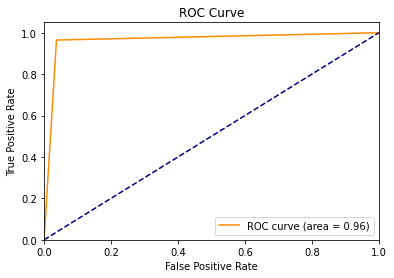

{'accuracy': 0.963771404992779,
 'precision': 0.964818324132817,
 'recall': 0.962914234026807,
 'f1': 0.9637714982580958}

In [236]:
get_spark_ml_perf(predictions)

# Feed Forward Network

In [237]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [238]:
train_df_features = vector_assembler.transform(train)
MLP = MultilayerPerceptronClassifier(layers=[train_df_features.schema["features"].metadata["ml_attr"]["num_attrs"], 4, 6,2], labelCol='default_ind', featuresCol='features', seed=42)
pipeline = Pipeline(stages=[vector_assembler, MLP])

In [239]:
mlp_clf = pipeline.fit(train)

In [240]:
predictions = mlp_clf.transform(test)

Summary Stats
Accuracy = 0.6884258304105633
Precision = 0.760334312175288
Recall = 0.5535728969657101
F1 Score = 0.682675395785765
Area under ROC = 0.7326346607454834


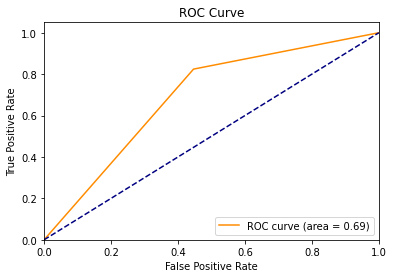

{'accuracy': 0.6884258304105633,
 'precision': 0.760334312175288,
 'recall': 0.5535728969657101,
 'f1': 0.682675395785765}

In [241]:
get_spark_ml_perf(predictions)

## Process Two (3 ML Models with TensorFlow and Keras)

In [242]:
import tensorflow as tf
import pandas as pd
pd.set_option('display.max_rows', None)

In [243]:
df_pandas = df.toPandas().sample(frac=1, random_state=42)

In [244]:
df_pandas = pd.get_dummies(data=df_pandas, columns=categorical_cols)

In [245]:
df_pandas = df_pandas.groupby('default_ind').sample(n=default_records, random_state=42).sample(frac=1)

In [246]:
uint8_cols = df_pandas.select_dtypes(include='uint8').columns.to_list()

In [247]:
df_pandas[uint8_cols] = df_pandas[uint8_cols].astype('int32')

In [248]:
split_index = int(0.7 * len(df_pandas))
(train, test) = (df_pandas[:split_index], df_pandas[split_index:])

In [249]:
import tensorflow_decision_forests as tfdf

In [250]:
X_train = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="default_ind")
X_test = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="default_ind")

### Decision Tree

In [251]:
model = tfdf.keras.RandomForestModel(num_trees=1)

Use /tmp/tmp1orfyc82 as temporary training directory


In [252]:
model.compile(metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [253]:
model.fit(X_train)

Reading training dataset...


2023-06-01 00:38:04.177031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_90' with dtype int32 and shape [56924]
	 [[{{node Placeholder/_90}}]]


Training dataset read in 0:00:01.884573. Found 56924 examples.
Training model...
Model trained in 0:00:00.231523
Compiling model...


[INFO 23-06-01 00:38:06.2858 AEST kernel.cc:1242] Loading model from path /tmp/tmp1orfyc82/model/ with prefix 4e4910c29c2149fd
[INFO 23-06-01 00:38:06.2871 AEST decision_forest.cc:660] Model loaded with 1 root(s), 1403 node(s), and 67 input feature(s).
[INFO 23-06-01 00:38:06.2871 AEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-01 00:38:06.2872 AEST kernel.cc:1074] Use fast generic engine
2023-06-01 00:38:06.293576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_69' with dtype int32 and shape [56924]
	 [[{{node Placeholder/_69}}]]


Model compiled.


In [254]:
model.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (108):
	acc_now_delinq
	annual_inc
	application_type_INDIVIDUAL
	application_type_JOINT
	collection_recovery_fee
	collections_12_mths_ex_med
	delinq_2yrs
	dti
	emp_length_10+_years
	emp_length_1_year
	emp_length_2_years
	emp_length_3_years
	emp_length_4_years
	emp_length_5_years
	emp_length_6_years
	emp_length_7_years
	emp_length_8_years
	emp_length_9_years
	emp_length_<_1_year
	emp_length_n/a
	funded_amnt
	grade_A
	grade_B
	grade_C
	grade_D
	grade_E
	grade_F
	grade_G
	home_ownership_MORTGAGE
	home_ownership_OTHER
	home_ownership_OWN
	home_ownership_RENT
	initial_list_status_f
	initial_list_status_w
	inq_last_6mths
	installment

In [255]:
model.evaluate(X_test)

2023-06-01 00:38:06.776643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_93' with dtype int32 and shape [24396]
	 [[{{node Placeholder/_93}}]]


25/25 [==============================] - 1s 26ms/step - loss: 0.0000e+00 - accuracy: 0.9617 - precision_5: 0.9689 - recall_5: 0.9546


[0.0, 0.9616740345954895, 0.9688738584518433, 0.9546083211898804]

In [256]:
y_pred = model.predict(X_test)

25/25 [==============================] - 1s 26ms/step


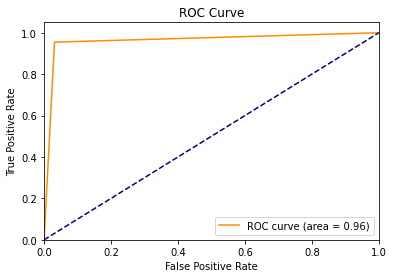

In [257]:
graph_roc_curve(test['default_ind'], y_pred)

### Random Forrest

In [258]:
model = tfdf.keras.RandomForestModel()

Use /tmp/tmp9on3btzc as temporary training directory


In [259]:
model.compile(metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [260]:
model.fit(X_train)

Reading training dataset...
Training dataset read in 0:00:01.883526. Found 56924 examples.
Training model...


[INFO 23-06-01 00:38:15.9018 AEST kernel.cc:1242] Loading model from path /tmp/tmp9on3btzc/model/ with prefix ffbe50a00d76467d


Model trained in 0:00:05.678977
Compiling model...


[INFO 23-06-01 00:38:16.2601 AEST decision_forest.cc:660] Model loaded with 300 root(s), 392366 node(s), and 103 input feature(s).
[INFO 23-06-01 00:38:16.2601 AEST kernel.cc:1074] Use fast generic engine
2023-06-01 00:38:16.328662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_102' with dtype double and shape [56924]
	 [[{{node Placeholder/_102}}]]


Model compiled.


In [261]:
model.summary()

Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (108):
	acc_now_delinq
	annual_inc
	application_type_INDIVIDUAL
	application_type_JOINT
	collection_recovery_fee
	collections_12_mths_ex_med
	delinq_2yrs
	dti
	emp_length_10+_years
	emp_length_1_year
	emp_length_2_years
	emp_length_3_years
	emp_length_4_years
	emp_length_5_years
	emp_length_6_years
	emp_length_7_years
	emp_length_8_years
	emp_length_9_years
	emp_length_<_1_year
	emp_length_n/a
	funded_amnt
	grade_A
	grade_B
	grade_C
	grade_D
	grade_E
	grade_F
	grade_G
	home_ownership_MORTGAGE
	home_ownership_OTHER
	home_ownership_OWN
	home_ownership_RENT
	initial_list_status_f
	initial_list_status_w
	inq_last_6mths
	installment

In [262]:
model.evaluate(X_test)

25/25 [==============================] - 1s 27ms/step - loss: 0.0000e+00 - accuracy: 0.9823 - precision_6: 0.9985 - recall_6: 0.9664


[0.0, 0.9823331832885742, 0.998487114906311, 0.9664036631584167]

In [263]:
y_pred = model.predict(X_test)

25/25 [==============================] - 1s 27ms/step


In [264]:
y_pred = model.predict(X_test)

25/25 [==============================] - 1s 28ms/step


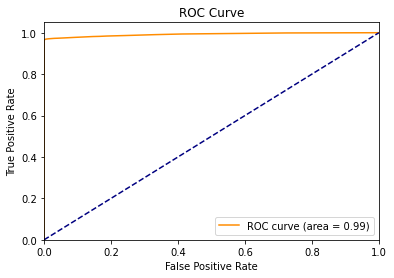

In [265]:
graph_roc_curve(test['default_ind'], y_pred)

### Feed Forward network

In [266]:
y_train = train['default_ind']
X_train = train.drop('default_ind', axis=1)
y_test = test['default_ind']
X_test = test.drop('default_ind', axis=1)

In [267]:
X_train.shape

(56924, 108)

In [268]:
from keras.models import Sequential
from keras.layers import Dense, Input

model = Sequential()
model.add(Input(shape=(108,)))
model.add(Dense(8, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [279]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [280]:
model.fit(X_train, y_train, epochs=50, batch_size=50, validation_split=0.2)

Epoch 1/50
911/911 [==============================] - 2s 1ms/step - loss: 0.0814 - accuracy: 0.9807 - val_loss: 0.0903 - val_accuracy: 0.9799
Epoch 2/50
911/911 [==============================] - 1s 574us/step - loss: 0.0784 - accuracy: 0.9813 - val_loss: 0.0839 - val_accuracy: 0.9810
Epoch 3/50
911/911 [==============================] - 1s 596us/step - loss: 0.0859 - accuracy: 0.9799 - val_loss: 0.0820 - val_accuracy: 0.9816
Epoch 4/50
911/911 [==============================] - 1s 566us/step - loss: 0.0758 - accuracy: 0.9823 - val_loss: 0.0811 - val_accuracy: 0.9814
Epoch 5/50
911/911 [==============================] - 1s 570us/step - loss: 0.1062 - accuracy: 0.9737 - val_loss: 0.2139 - val_accuracy: 0.9477
Epoch 6/50
911/911 [==============================] - 1s 589us/step - loss: 0.0816 - accuracy: 0.9801 - val_loss: 0.0820 - val_accuracy: 0.9817
Epoch 7/50
911/911 [==============================] - 1s 594us/step - loss: 0.0840 - accuracy: 0.9793 - val_loss: 0.0869 - val_accuracy: 0

In [281]:
model.evaluate(X_test, y_test)

763/763 [==============================] - 0s 383us/step - loss: 0.0747 - accuracy: 0.9825


[0.07470446079969406, 0.9824971556663513]

In [282]:
y_pred = model.predict(X_test)

763/763 [==============================] - 0s 325us/step


In [283]:
y_pred = y_pred.argmax(axis=1)

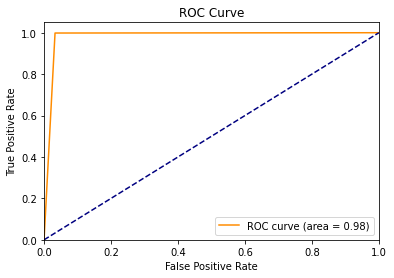

In [284]:
graph_roc_curve(y_pred, y_test)

In [285]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))

0.9828759679961454
0.9826208991064715
